#SongTron

In [1]:
"""
def binarize(image):
    #Binarizing image
    arr = image.flatten()
    mean = arr.mean()
    print("mean: {}".format(mean))

"""
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [14]:
def kernel_horizontal(bin_im):
    horizontal = np.copy(bin_im)
    rows = horizontal.shape[1]
    size = rows//30
    structure = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    print(structure)
    horizontal = cv2.erode(horizontal, structure)
    horizontal = cv2.dilate(horizontal, structure)
    return horizontal

def conv2d_image(f, w):
    N, M = f.shape[0:2]
    n, m = w.shape[0:2]
    w_flip = np.flip(np.flip(w, 0), 1)
    a = n//2  # floor of n/2
    b = m//2  # floor of m/2
    g = np.zeros(f.shape, dtype=np.float)
    for x in range(a, N-a):
        for y in range(b, M-b):
            region_f = f[x-a:x+(a+1), y-b:y+(b+1)]
            g[x][y] = np.sum(np.multiply(region_f.astype(np.float), w_flip.astype(np.float)))
    return g


def otsu_threshold(im):

    # Compute histogram and probabilities of each intensity level
    pixel_counts = [np.sum(im == i) for i in range(256)]
    n, m = im.shape[0:2]
    # Initialization
    s_max = (0,0)

    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)])\
                        / w_0 if w_0 > 0 else 0
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)])\
                        / w_1 if w_1 > 0 else 0

        # calculate - inter class variance
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]

def threshold(pic, threshold):
    return ((pic < threshold) * 255).astype('uint8')

### Image segmentation stuff

In [55]:
def distance(a, b):
    return np.abs(a-b)

def region_growing_average(img, img_t, tolerance, seed, region_n): 
    
    #img_t = np.zeros(img.shape)
    x = seed[0]; y = seed[1]

    img_t[x, y] = region_n
    
    avg = np.mean(img[np.where(img_t==region_n)])
    
    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x, y+1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y+1], region_n)
        
    if (y-1 >= 0 and img_t[x,y-1] == 0  and distance(avg, img[x, y-1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y-1], region_n)
        
    if (x+1 < img.shape[0] and img_t[x+1,y] == 0  and distance(avg, img[x+1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x+1, y], region_n)
        
    if (x-1 >= 0 and img_t[x-1,y] == 0  and distance(avg, img[x-1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x-1, y], region_n)
        
def do_segmentation(image, thresh):
    segment_matrix = np.zeros(image.shape)
    region_counter = 1
    
    #Will check if region is above some treshold
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            pixel_val = image[x, y]
            if segment_matrix[x, y] == 0 and pixel_val >= thresh: #in case not assigned yet
                region_growing_average(image, segment_matrix, 10, (x, y), region_counter)
                region_counter += 1
                print("X: {} Y: {} Region: {}".format(x,y,region_counter))
    #print("Segmented regions: {}".format(region_counter))
    return segment_matrix

In [80]:
def get_bounding_rectangle(segment_matrix, segment_number):
    segment_indexes = np.where(segment_matrix == segment_number)
    max_x = segment_indexes[0].max()
    min_x = segment_indexes[0].min()
    max_y = segment_indexes[1].max()
    min_y = segment_indexes[1].min()
    return (min_x, max_x, min_y, max_y)

In [87]:
def main(filename):
    pic = imageio.imread(filename)
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07])

    plt.figure(figsize=(12,12))
    plt.title("Original")
    plt.imshow(pic, cmap='gray')
    plt.axis('off')
    
    bin_img = threshold(gray(pic), otsu_threshold(pic))
    plt.figure(figsize=(12,12))
    plt.title("Binarized")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')

    lines = kernel_horizontal(bin_img)
    plt.figure(figsize=(12,12))
    plt.title("Lines")
    plt.imshow(lines, cmap='gray')
    plt.axis('off')

    bin_img[lines == 255] = 0 
    plt.figure(figsize=(12,12))
    plt.title("Lines removed")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    """
    blurred = cv2.medianBlur(bin_img, 5)
    plt.figure(figsize=(12,12))
    plt.title("Blurred")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')
    """
    kernel = np.ones((4,1),np.uint8)
    closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(12,12))
    plt.title("Morphological Close")
    plt.imshow(closing, cmap='gray')
    plt.axis('off')

    segmented = do_segmentation(closing, otsu_threshold(pic))
    
    mask = np.zeros(segmented.shape)
    mask[segmented > 0] = 1
    
    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented, cmap='magma')
    plt.axis('off')

    plt.figure(figsize=(20,20))
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    #Dilating image now...
    kernel_dilate = np.ones((3,3),np.uint8)
    dilated_mask = cv2.dilate(mask, kernel_dilate)
    
    plt.figure(figsize=(20,20))
    plt.title("Dilated mask")
    plt.imshow(dilated_mask, cmap='gray')
    plt.axis('off')
    
    for region in np.unique(segmented):
        ranges = get_bounding_rectangle(segmented, region)
        print("Ranges are {}".format(ranges))
        temp = np.copy(closing)
        img = temp[ranges[0]:ranges[1],ranges[2]:ranges[3]]
        plt.figure(figsize=(4,4))
        plt.title("Figure nº {}".format(region))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.show()

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
X: 4 Y: 34 Region: 2
X: 10 Y: 78 Region: 3
X: 10 Y: 96 Region: 4
X: 20 Y: 43 Region: 5
X: 27 Y: 43 Region: 6
X: 55 Y: 37 Region: 7
X: 60 Y: 235 Region: 8
X: 60 Y: 326 Region: 9
X: 60 Y: 417 Region: 10
X: 74 Y: 5 Region: 11
X: 76 Y: 82 Region: 12
X: 76 Y: 493 Region: 13
X: 76 Y: 624 Region: 14
X: 76 Y: 715 Region: 15
X: 76 Y: 806 Region: 16
X: 76 Y: 882 Region: 17
X: 76 Y: 1179 Region: 18
X: 76 Y: 1187 Region: 19
X: 82 Y: 533 Region: 20
X: 91 Y: 1023 Region: 21
X: 105 Y: 139 Region: 22
Ranges are (0, 180, 0, 1201)
Ranges are (4, 41, 20, 35)
Ranges are (10, 33, 71, 85)
Ranges are (10, 32, 89, 103)
Ranges are (20, 22, 43, 58)
Ranges are (27, 29, 43, 58)
Ranges are (55, 156, 13, 51)
Ranges are (60, 116, 219, 235)
Ranges are (60, 116, 310, 327)
Ranges are (60, 116, 402, 418)
Ranges are (74, 133, 4, 6)
Ranges are (76, 131, 74, 98)
Ranges are (76, 131, 493, 495)
Ranges are (76, 131, 609, 625)
Ranges are (76,

/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Ranges are (76, 131, 882, 884)
Ranges are (76, 131, 1179, 1180)
Ranges are (76, 131, 1187, 1193)
Ranges are (82, 139, 517, 534)
Ranges are (91, 96, 1023, 1039)
Ranges are (105, 161, 118, 146)


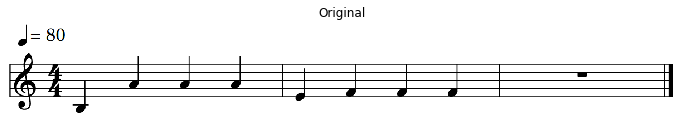

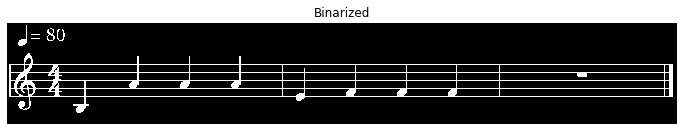

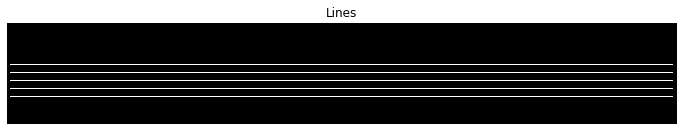

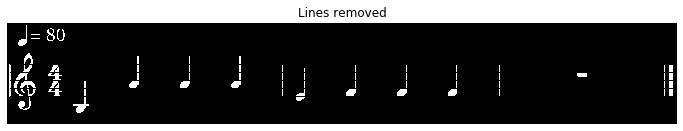

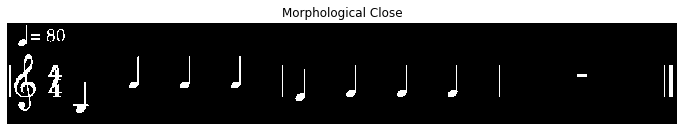

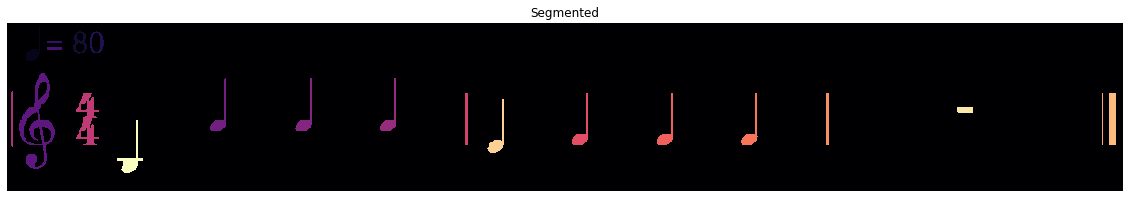

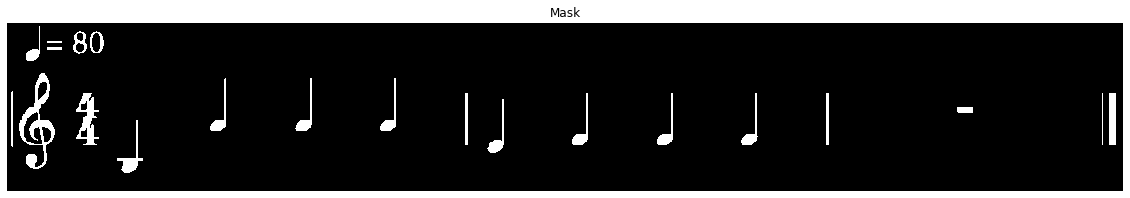

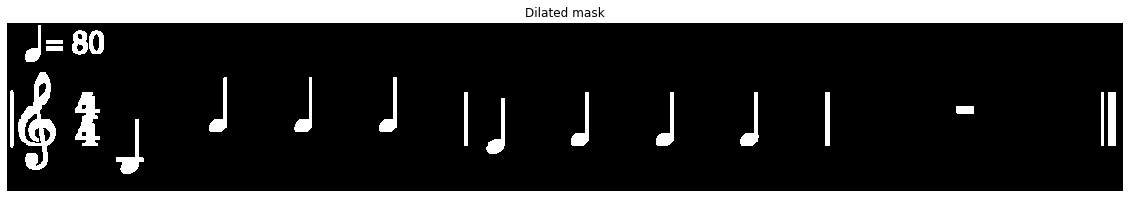

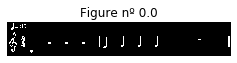

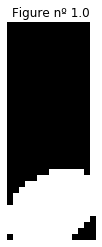

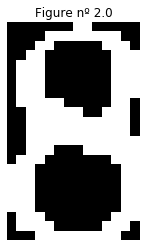

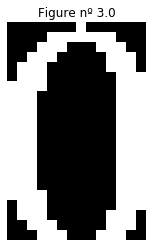

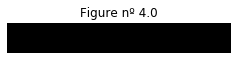

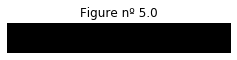

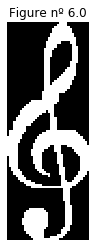

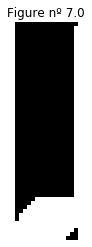

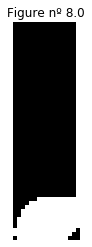

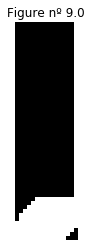

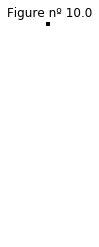

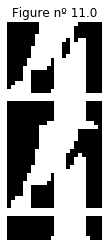

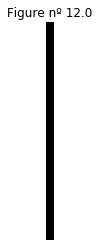

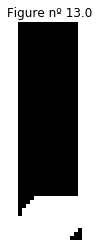

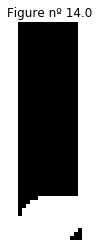

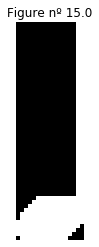

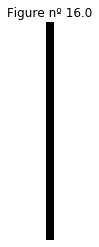

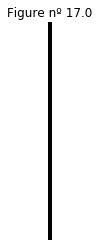

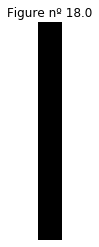

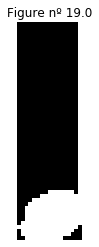

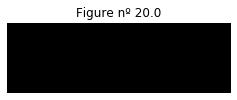

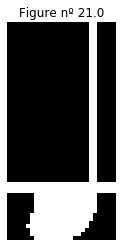

In [88]:
file1 = "../assets/songtron_test_0.png"
main(file1)    

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
X: 11 Y: 33 Region: 2
X: 15 Y: 594 Region: 3
X: 15 Y: 680 Region: 4
X: 15 Y: 706 Region: 5
X: 16 Y: 53 Region: 6
X: 18 Y: 556 Region: 7
X: 19 Y: 142 Region: 8
X: 19 Y: 237 Region: 9
X: 19 Y: 617 Region: 10
X: 20 Y: 262 Region: 11
X: 20 Y: 333 Region: 12
X: 20 Y: 407 Region: 13
X: 20 Y: 454 Region: 14
X: 20 Y: 498 Region: 15
X: 20 Y: 534 Region: 16
X: 24 Y: 67 Region: 17
X: 25 Y: 22 Region: 18
X: 26 Y: 46 Region: 19
X: 26 Y: 90 Region: 20
X: 26 Y: 124 Region: 21
X: 26 Y: 168 Region: 22
X: 26 Y: 180 Region: 23
X: 26 Y: 205 Region: 24
X: 26 Y: 219 Region: 25
X: 26 Y: 270 Region: 26
X: 26 Y: 282 Region: 27
X: 26 Y: 307 Region: 28
X: 26 Y: 344 Region: 29
X: 26 Y: 356 Region: 30
X: 26 Y: 381 Region: 31
X: 26 Y: 418 Region: 32
X: 26 Y: 430 Region: 33
X: 26 Y: 465 Region: 34
X: 26 Y: 481 Region: 35
X: 26 Y: 510 Region: 36
X: 26 Y: 543 Region: 37
X: 26 Y: 629 Region: 38
X: 26 Y: 715 Region: 39
X: 28 Y: 100 Region: 40
X: 32 Y: 22 Region: 41
X: 

/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


Ranges are (24, 51, 64, 74)
Ranges are (25, 25, 22, 22)
Ranges are (26, 43, 46, 52)
Ranges are (26, 63, 88, 97)
Ranges are (26, 51, 123, 124)
Ranges are (26, 51, 168, 169)
Ranges are (26, 63, 177, 187)
Ranges are (26, 63, 203, 212)
Ranges are (26, 51, 219, 220)
Ranges are (26, 51, 270, 271)
Ranges are (26, 65, 279, 300)
Ranges are (26, 62, 304, 313)
Ranges are (26, 51, 344, 345)
Ranges are (26, 65, 353, 375)
Ranges are (26, 63, 378, 387)
Ranges are (26, 51, 418, 419)
Ranges are (26, 63, 428, 436)
Ranges are (26, 63, 463, 471)
Ranges are (26, 51, 480, 481)
Ranges are (26, 63, 507, 516)
Ranges are (26, 51, 543, 544)
Ranges are (26, 51, 629, 630)
Ranges are (26, 51, 715, 716)
Ranges are (28, 30, 100, 102)
Ranges are (32, 32, 22, 22)
Ranges are (33, 44, 0, 1)
Ranges are (35, 60, 638, 647)
Ranges are (37, 44, 3, 5)
Ranges are (37, 44, 6, 9)
Ranges are (38, 39, 22, 22)
Ranges are (42, 44, 100, 102)
Ranges are (42, 44, 145, 147)
Ranges are (45, 46, 22, 22)
Ranges are (52, 53, 22, 22)
Ranges a

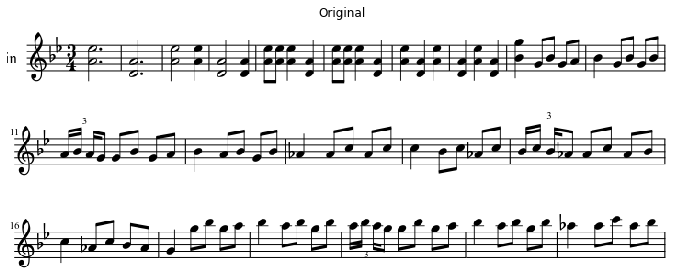

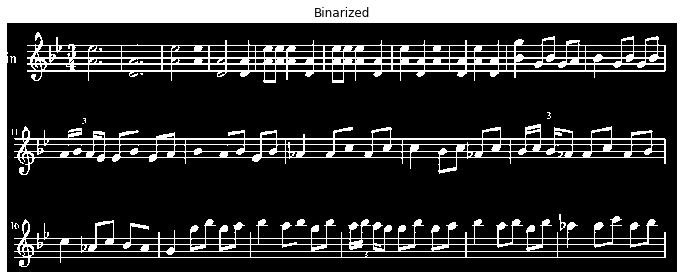

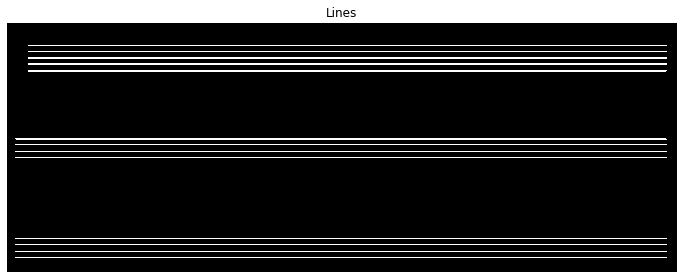

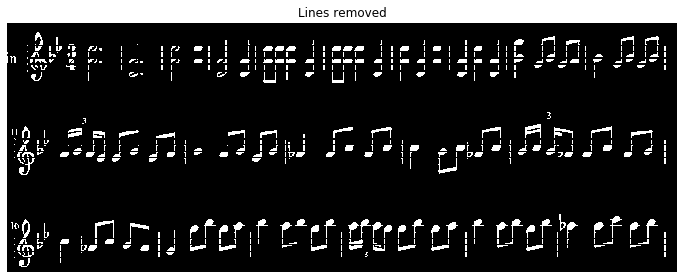

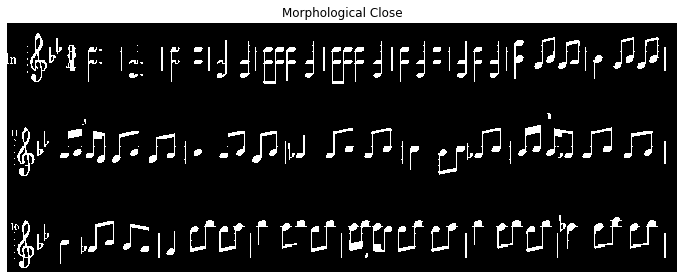

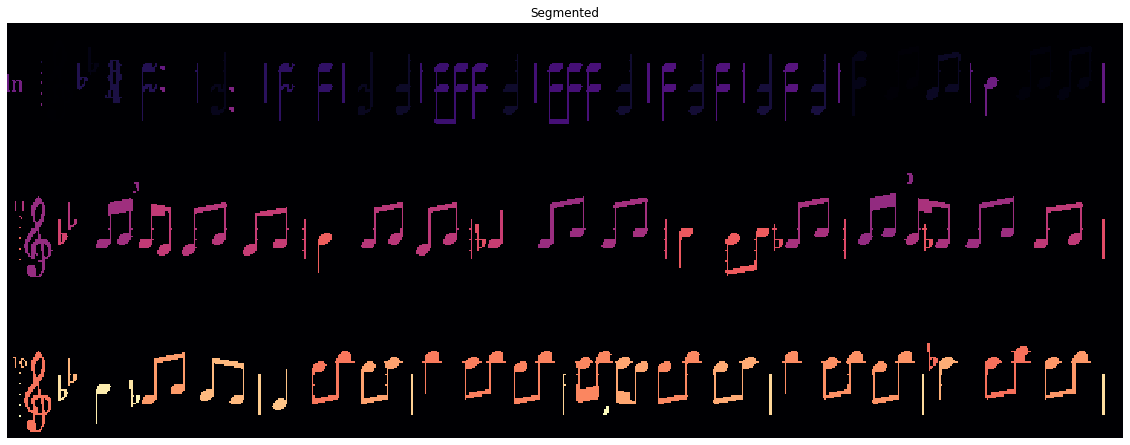

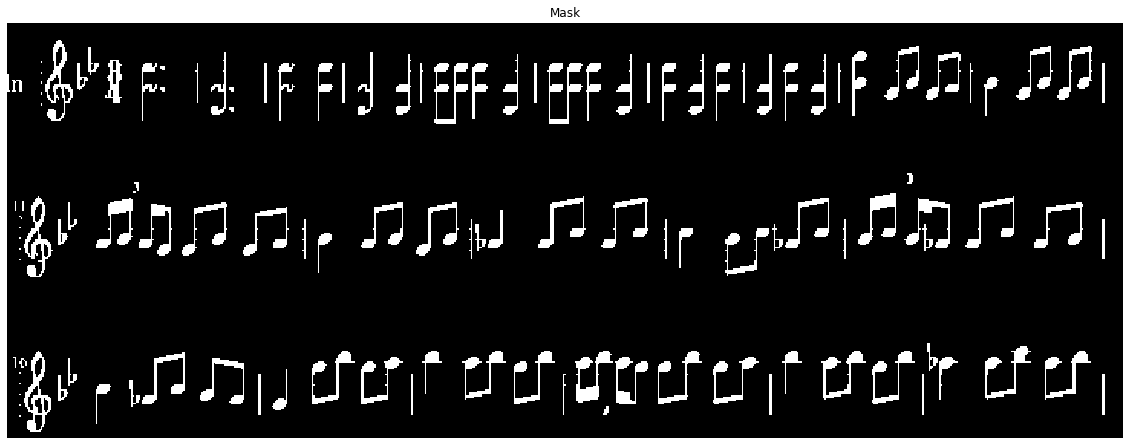

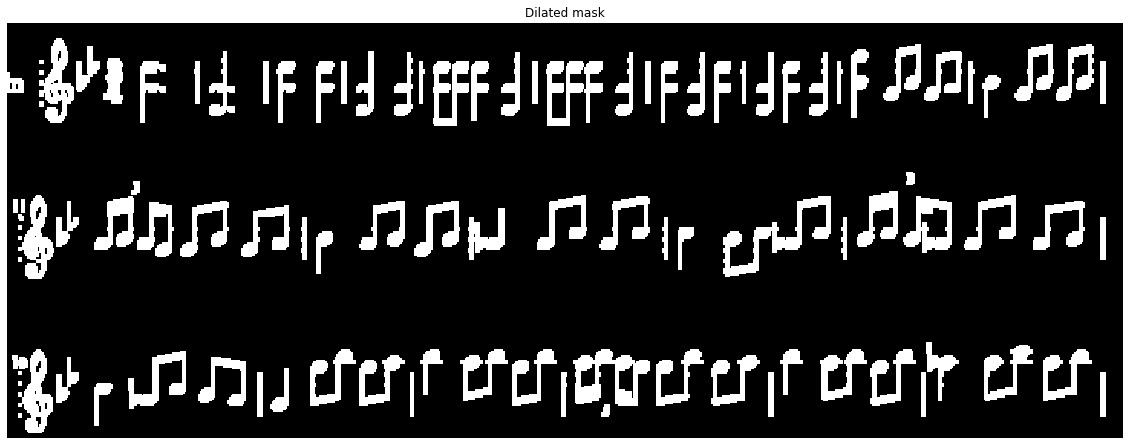

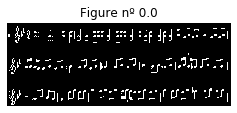

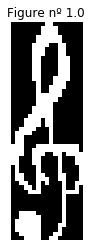

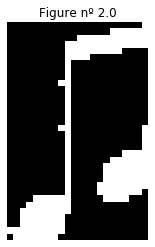

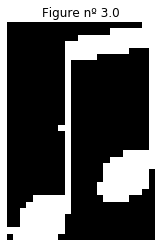

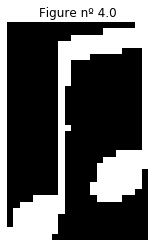

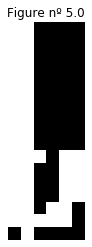

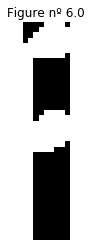

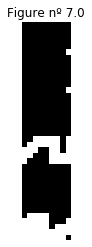

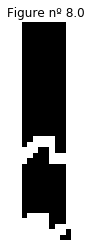

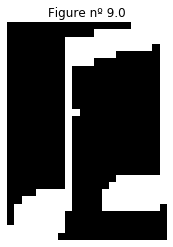

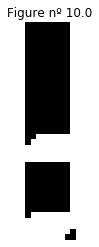

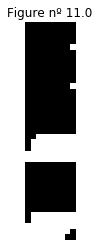

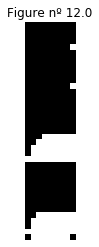

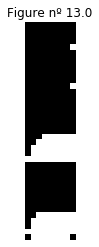

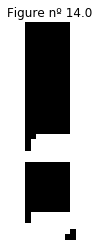

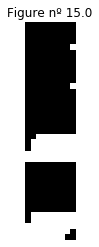

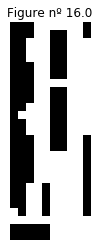

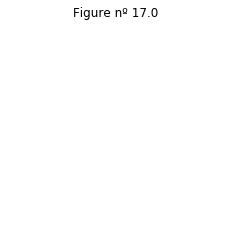

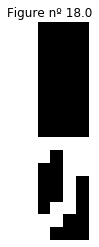

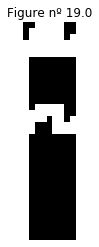

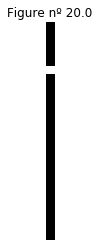

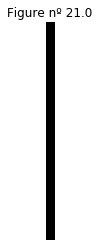

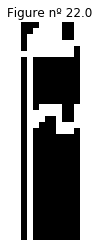

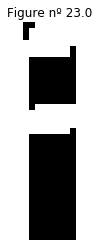

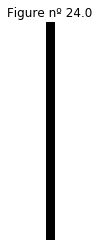

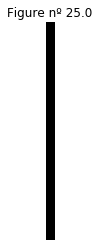

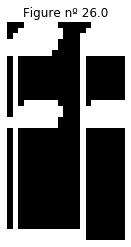

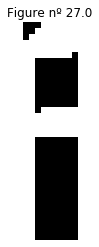

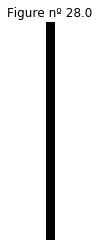

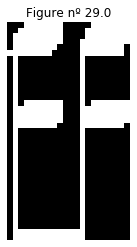

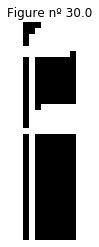

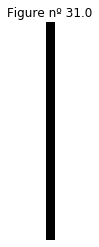

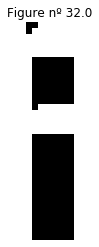

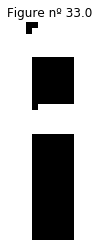

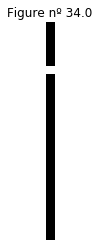

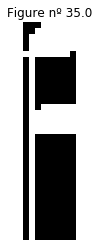

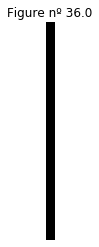

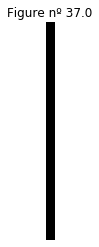

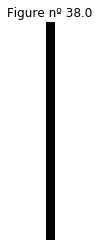

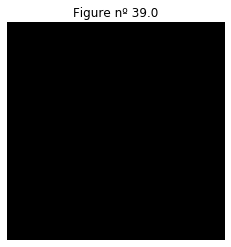

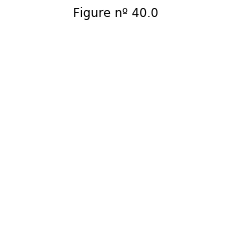

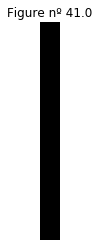

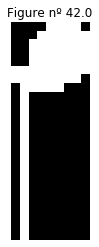

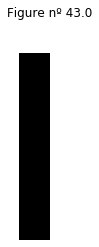

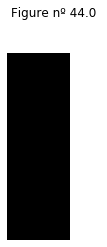

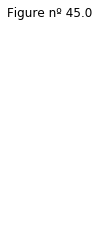

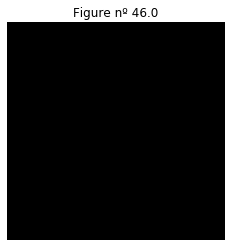

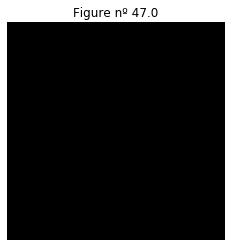

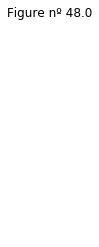

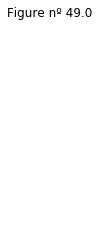

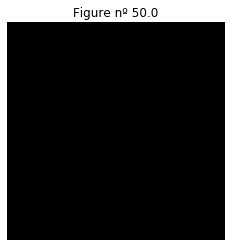

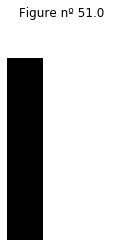

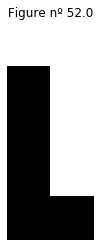

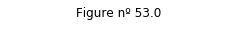

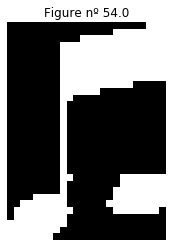

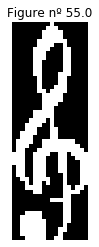

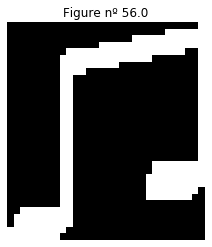

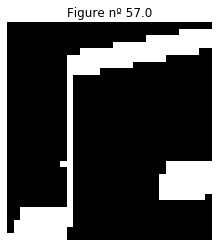

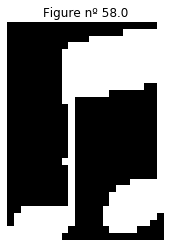

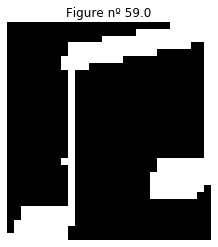

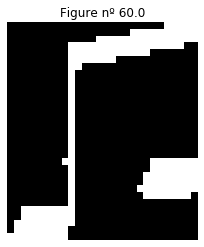

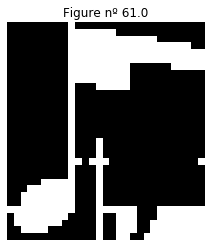

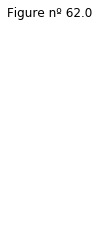

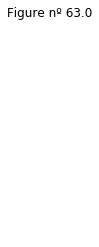

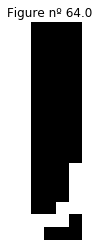

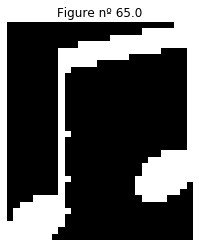

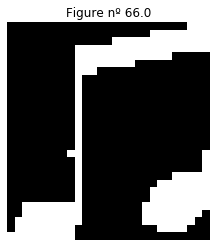

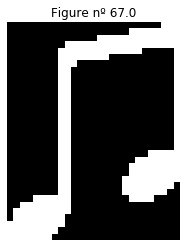

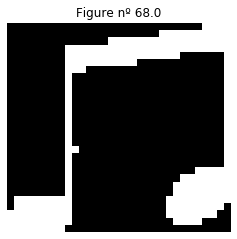

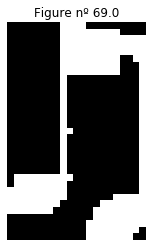

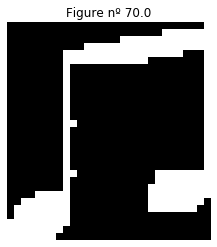

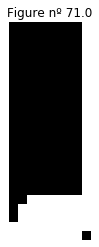

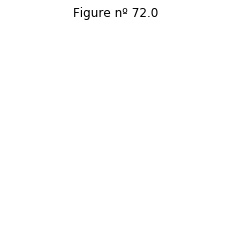

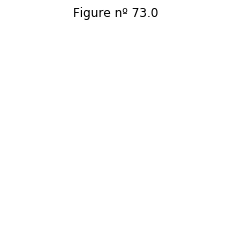

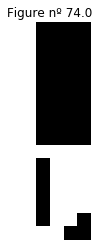

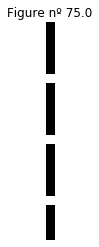

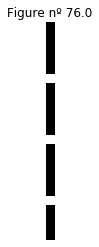

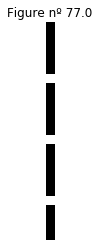

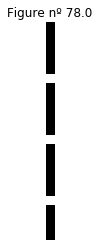

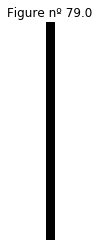

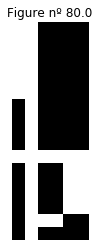

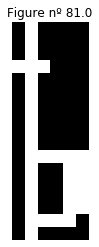

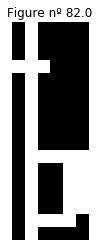

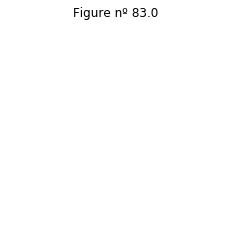

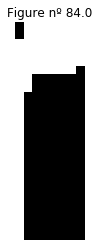

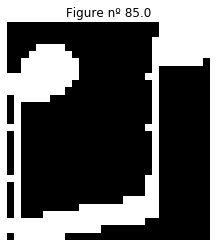

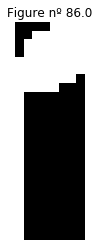

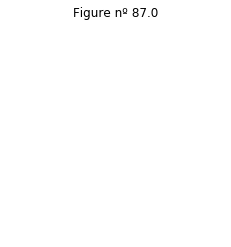

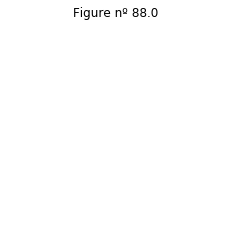

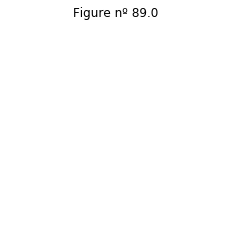

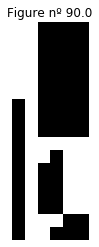

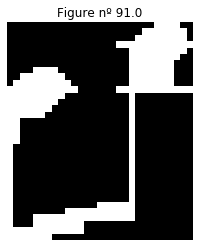

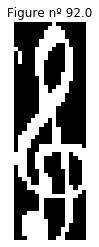

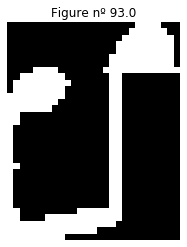

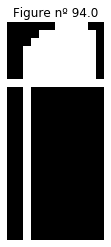

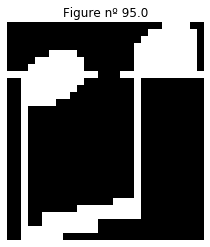

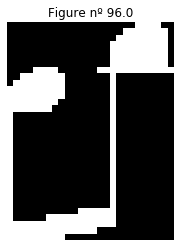

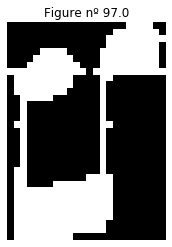

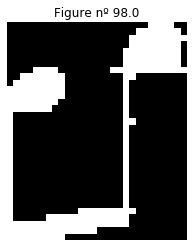

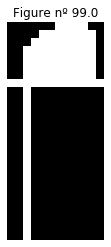

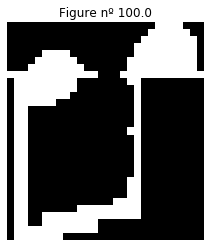

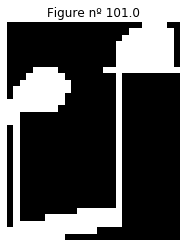

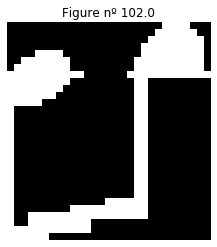

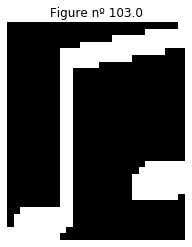

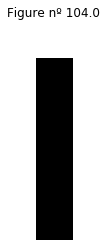

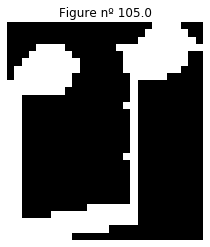

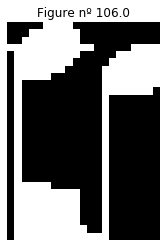

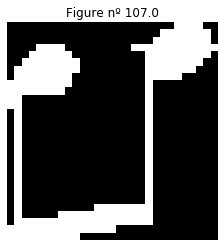

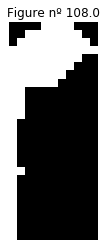

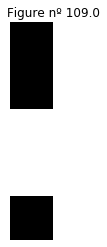

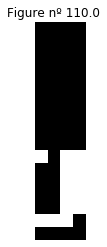

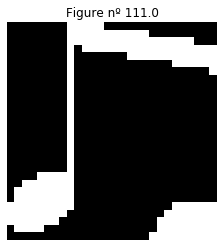

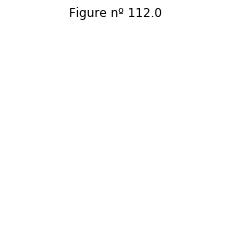

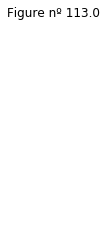

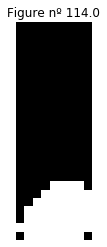

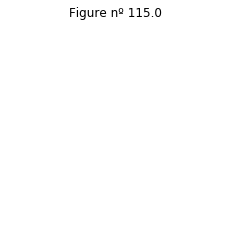

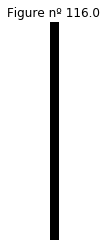

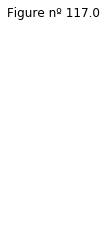

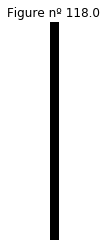

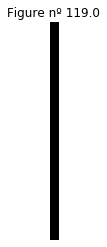

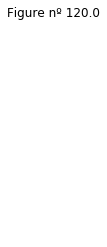

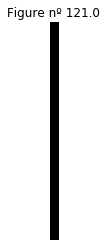

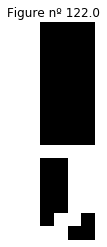

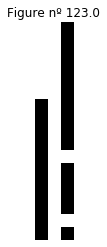

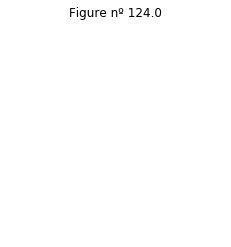

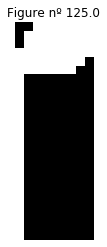

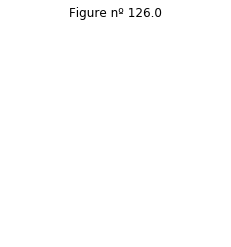

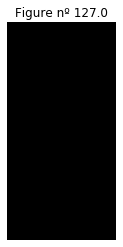

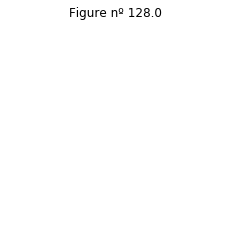

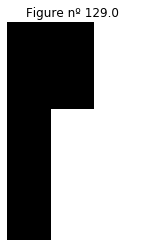

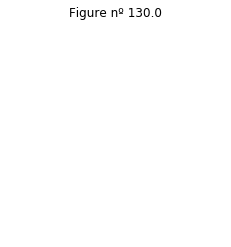

In [89]:
file2 = "../assets/danse_macabre_cut_0.png"
main(file2)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
X: 0 Y: 815 Region: 2
X: 38 Y: 354 Region: 3
X: 38 Y: 494 Region: 4
X: 39 Y: 337 Region: 5
X: 39 Y: 375 Region: 6
X: 39 Y: 400 Region: 7
X: 39 Y: 420 Region: 8
X: 39 Y: 463 Region: 9
X: 39 Y: 515 Region: 10
X: 106 Y: 93 Region: 11
X: 108 Y: 113 Region: 12
X: 111 Y: 199 Region: 13
X: 111 Y: 575 Region: 14
X: 120 Y: 218 Region: 15
X: 120 Y: 310 Region: 16
X: 120 Y: 402 Region: 17
X: 120 Y: 494 Region: 18
X: 120 Y: 595 Region: 19
X: 120 Y: 687 Region: 20
X: 120 Y: 779 Region: 21
X: 121 Y: 477 Region: 22
X: 123 Y: 128 Region: 23
X: 123 Y: 271 Region: 24
X: 123 Y: 321 Region: 25
X: 123 Y: 461 Region: 26
X: 123 Y: 499 Region: 27
X: 123 Y: 648 Region: 28
X: 123 Y: 699 Region: 29
X: 124 Y: 503 Region: 30
X: 125 Y: 129 Region: 31
X: 128 Y: 413 Region: 32
X: 128 Y: 454 Region: 33
X: 128 Y: 504 Region: 34
X: 128 Y: 740 Region: 35
X: 131 Y: 231 Region: 36
X: 131 Y: 364 Region: 37
X: 131 Y: 608 Region: 38
X: 233 Y: 94 Region: 39
X: 234 Y: 65

/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


Ranges are (39, 62, 420, 461)
Ranges are (39, 62, 463, 483)
Ranges are (39, 62, 506, 525)
Ranges are (106, 166, 82, 100)
Ranges are (108, 128, 108, 114)
Ranges are (111, 147, 167, 201)
Ranges are (111, 147, 543, 578)
Ranges are (120, 150, 218, 219)
Ranges are (120, 150, 310, 311)
Ranges are (120, 150, 401, 403)
Ranges are (120, 150, 493, 494)
Ranges are (120, 150, 595, 596)
Ranges are (120, 150, 687, 688)


/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/hiram/Workspace/miniconda3/envs/imgproc/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


Ranges are (120, 150, 779, 780)
Ranges are (121, 121, 477, 486)
Ranges are (123, 124, 128, 128)
Ranges are (123, 155, 268, 276)
Ranges are (123, 155, 318, 327)
Ranges are (123, 123, 461, 463)
Ranges are (123, 123, 499, 501)
Ranges are (123, 155, 645, 654)
Ranges are (123, 155, 695, 704)
Ranges are (124, 124, 503, 503)
Ranges are (125, 146, 126, 132)
Ranges are (128, 159, 410, 419)
Ranges are (128, 159, 452, 460)
Ranges are (128, 159, 502, 511)
Ranges are (128, 159, 737, 746)
Ranges are (131, 163, 226, 235)
Ranges are (131, 163, 360, 368)
Ranges are (131, 163, 603, 612)
Ranges are (233, 291, 81, 100)
Ranges are (234, 270, 642, 676)
Ranges are (236, 257, 108, 114)
Ranges are (238, 270, 700, 708)
Ranges are (239, 275, 252, 286)
Ranges are (242, 275, 226, 239)
Ranges are (243, 275, 506, 515)
Ranges are (248, 279, 192, 193)
Ranges are (248, 279, 302, 304)
Ranges are (248, 279, 391, 393)
Ranges are (248, 279, 497, 499)
Ranges are (248, 279, 585, 586)
Ranges are (248, 279, 691, 693)
Ranges ar

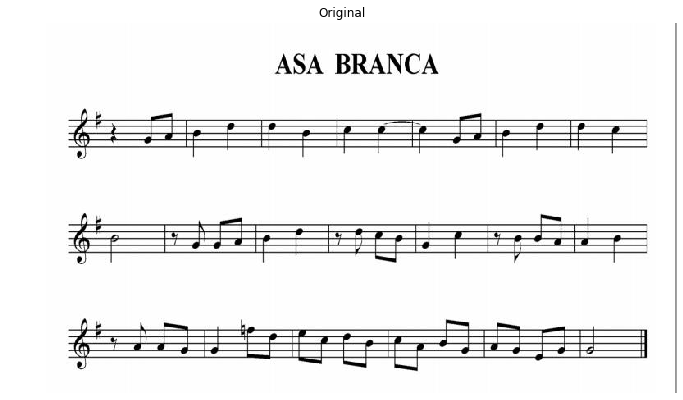

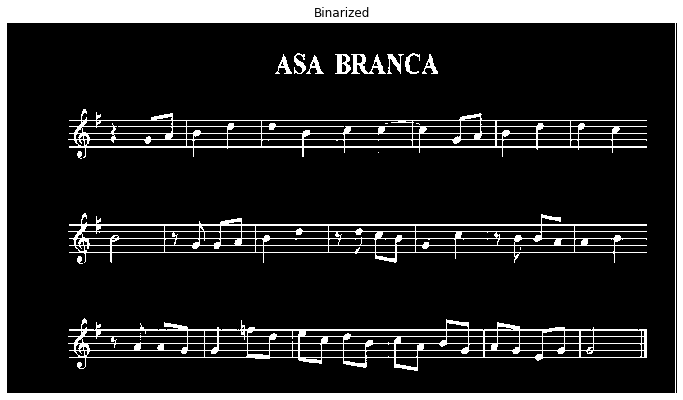

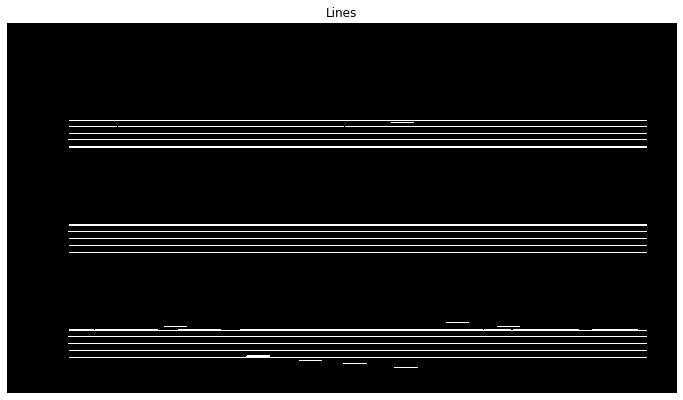

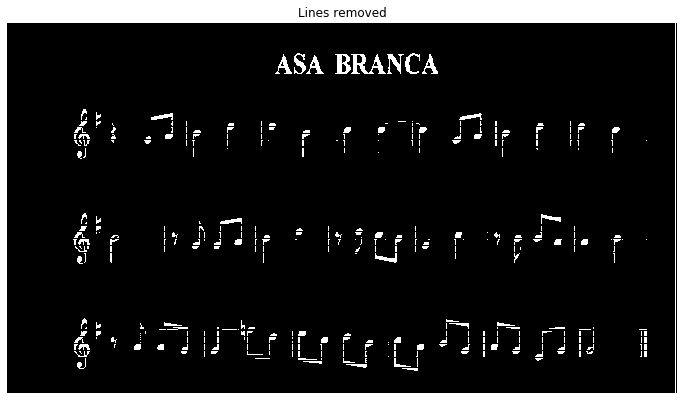

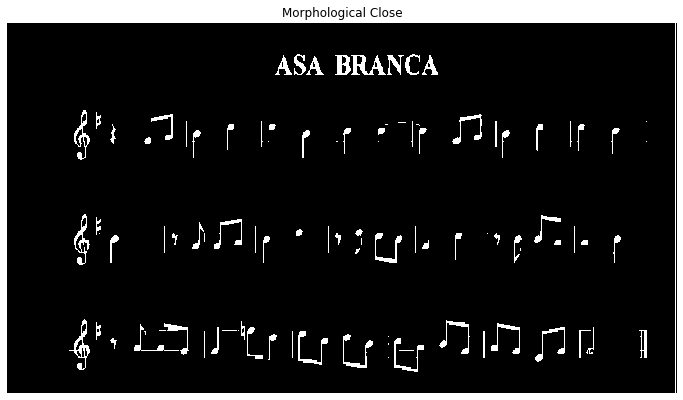

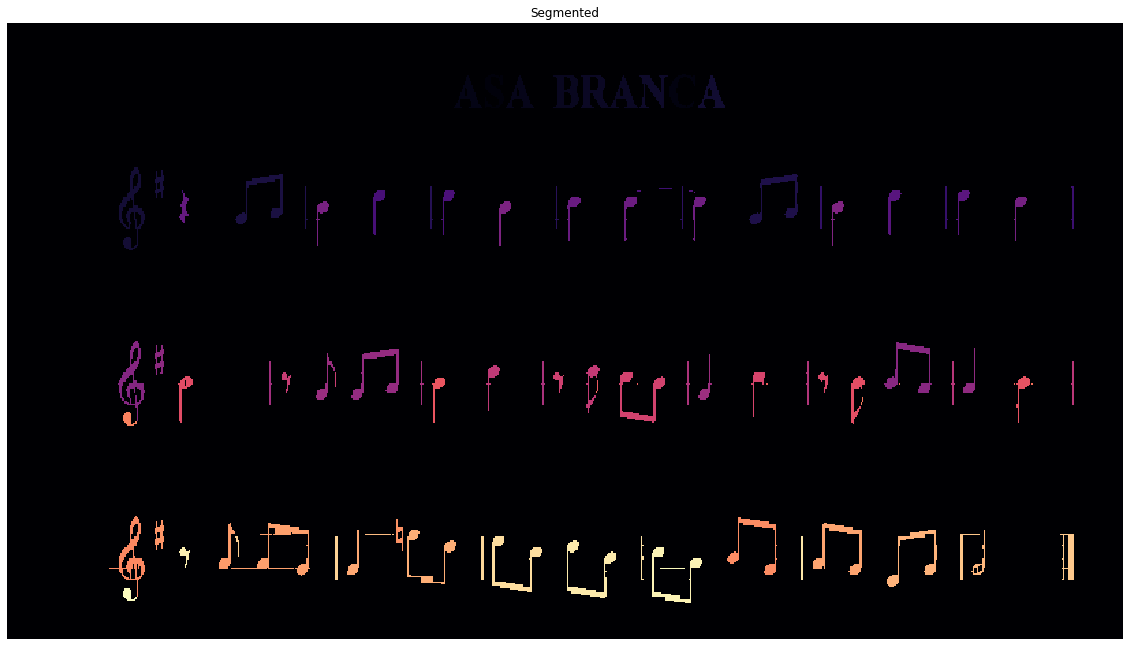

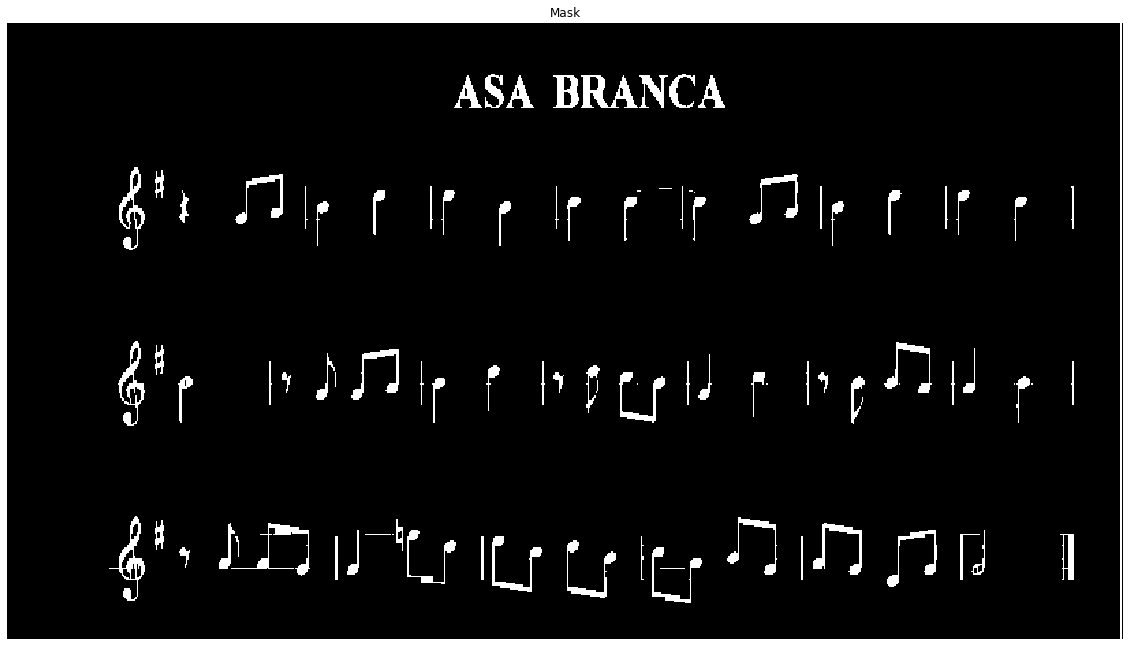

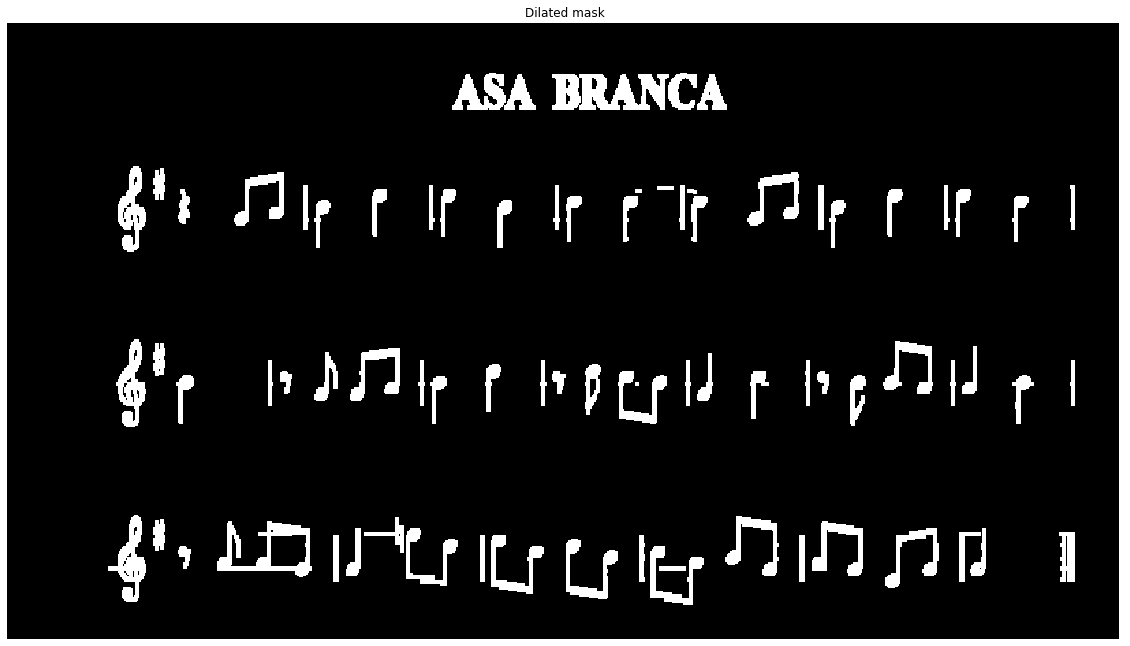

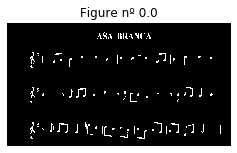

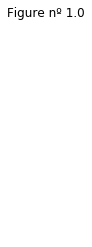

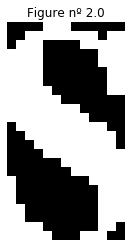

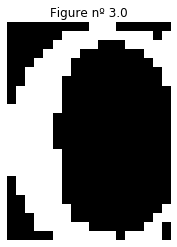

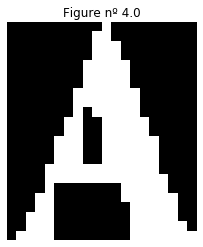

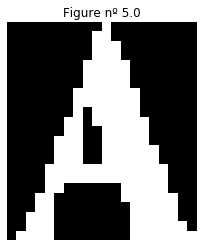

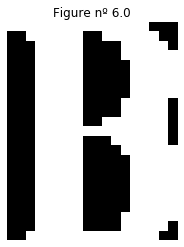

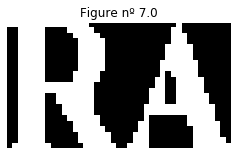

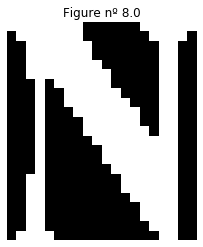

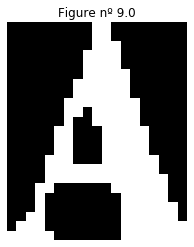

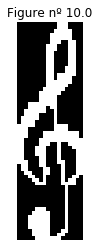

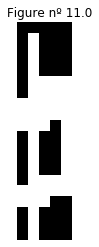

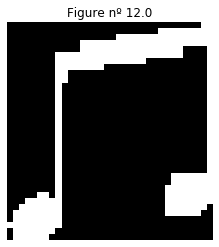

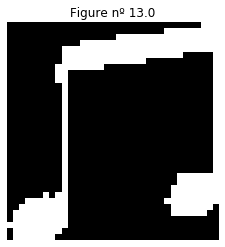

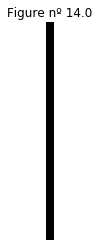

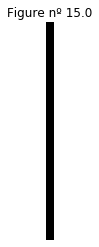

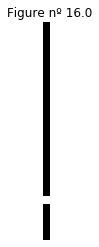

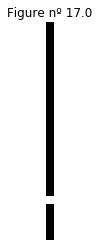

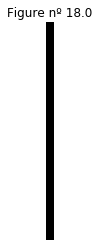

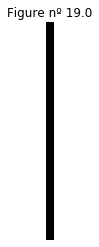

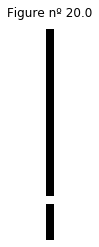

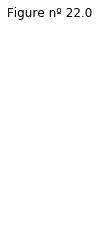

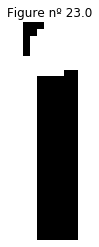

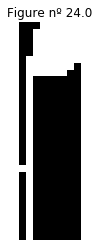

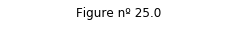

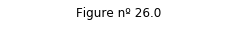

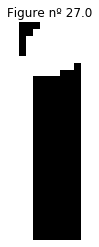

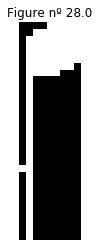

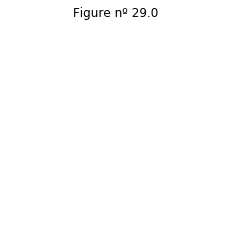

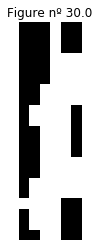

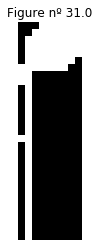

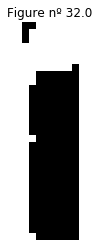

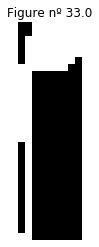

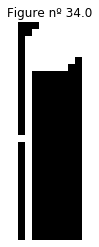

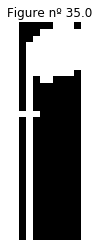

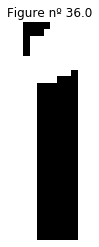

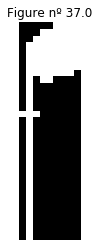

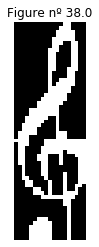

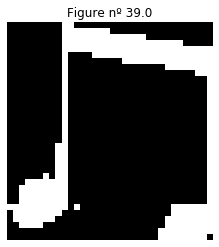

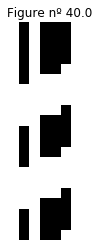

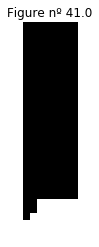

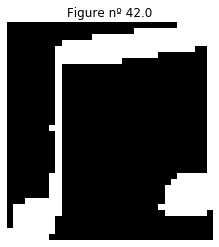

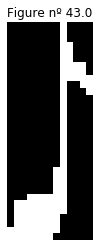

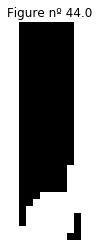

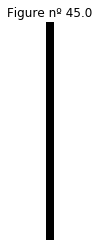

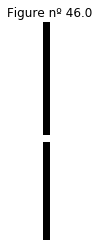

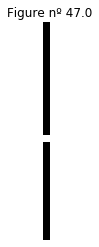

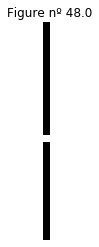

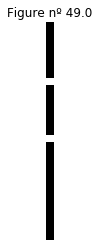

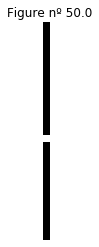

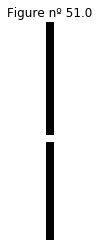

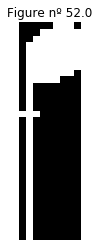

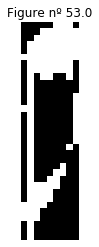

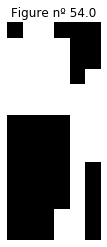

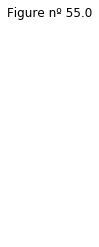

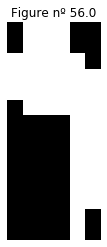

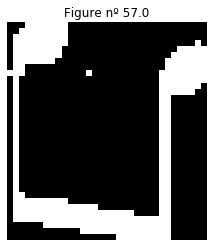

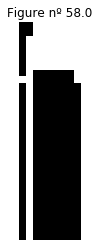

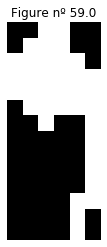

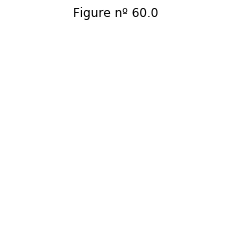

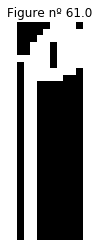

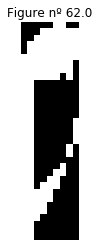

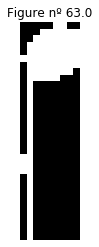

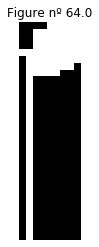

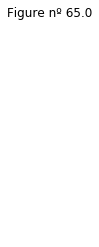

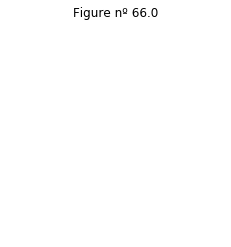

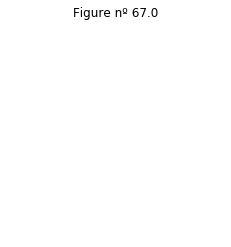

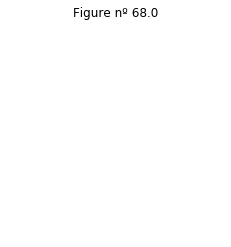

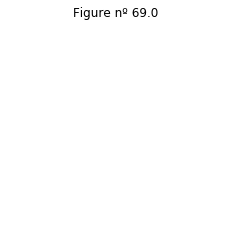

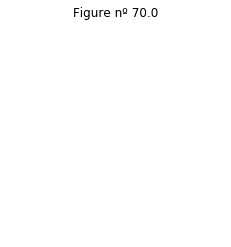

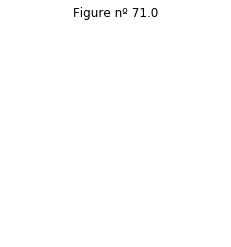

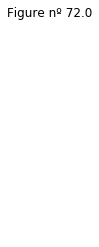

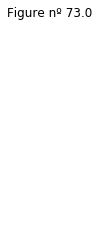

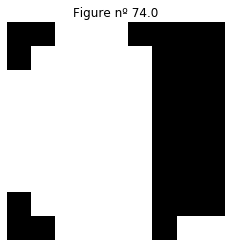

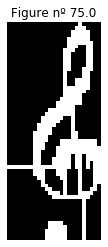

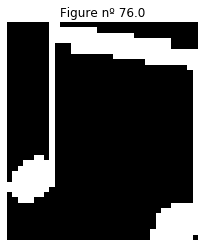

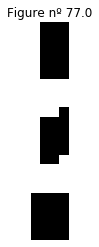

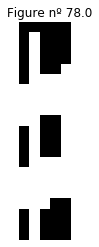

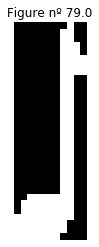

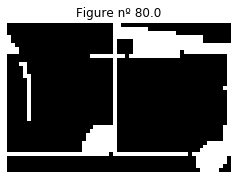

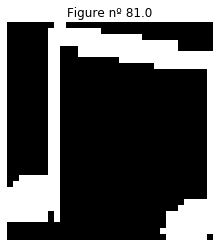

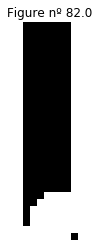

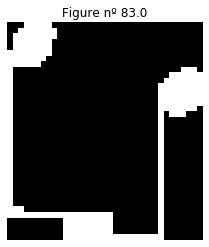

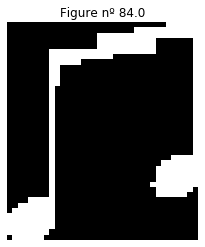

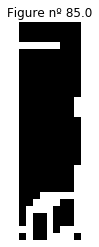

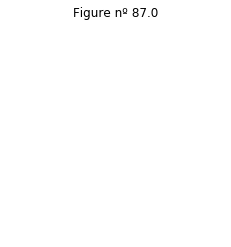

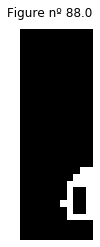

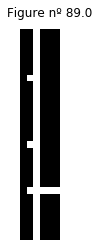

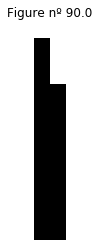

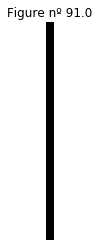

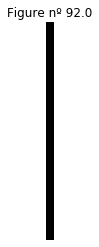

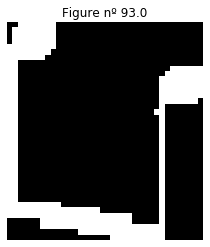

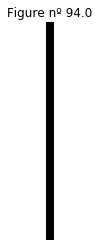

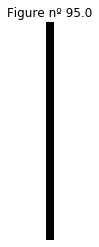

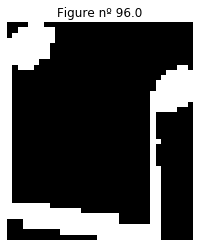

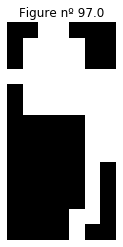

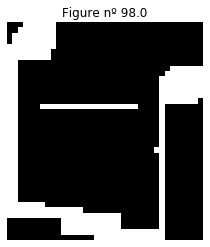

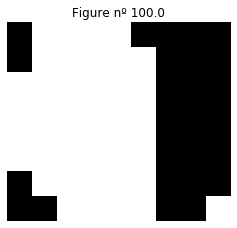

In [90]:
file3 = "../assets/asa_branca.jpg"
main(file3)